In [1]:
import altair as alt
import matplotlib.pyplot as plt
import lake_model_func as model
import numpy as np
import pandas as pd
import seaborn as sn
from scipy.integrate import odeint

alt.data_transformers.disable_max_rows()
plt.style.use('ggplot')

# The TPKALK box model

## 1. Model formulation

Notebook implementing the box model for TPKALK outlined [here](https://niva.brage.unit.no/niva-xmlui/bitstream/handle/11250/208709/3412_200dpi.pdf?sequence=2&isAllowed=y#page=34). 

The model is illustrated below.

<img src="../docs/images/box_model.png" width="600">

Where:

 * $D$ is the dose of lime added (adjusted for Ca content i.e. the actual dose of Ca in mg/l)
 * $C_{inst}$ is the "immediate" increase in lake Ca concentration (in mg/l) due to **instantaneous dissolution**
 * $C_{bott} = F_{active} (D - C_{inst})$ is the amount of Ca (in mg/l) that sinks to the lake bottom and remains active for dissolution. Note that $(D - C_{inst})$ is the total amount of lime that sinks to the bottom, and $F_{active}$ is the proportion of this that remains "active". Typical values for $F_{active}$ are around 0.4, based on the observation that about 60% of the lime arriving on the lake bottom becomes "deactivated" and never dissolves.
 * $F_{slow}$ is the rate at which concentration increases (in mg/l/month) due to dissolution of the bottom layer
 * $C_{in}$ and $C_{out}$ are the inflow and outflow concentrations of Ca, respectively (both in mg/l)
 * $V$ is the lake volume in litres. The lake is assumed to be in **steady state** i.e. $V$ is constant
 * $Q$ is the discharge in l/month. To satisfy the steady state assumption, the inflow discharge must equal the outflow discharge
 * $M_{lake}$ is the mass of Ca dissolved in the lake water (in mg)
 * $C_{lake}$ is the Ca concentration in the lake, equal to $\frac{M_{lake}}{V}$. The lake is assumed to be **well mixed**, such that the outflow concentration, $C_{out}$, is equal to $C_{lake}$
 
Balancing sources and sinks of Ca gives

$$
\frac{dM_{lake}}{dt} = V \frac{dC_{lake}}{dt} = Q C_{in} - Q C_{lake} + V C_{inst} + V F_{slow}
$$

or

$$
\frac{dC_{lake}}{dt} = \frac{Q C_{in} - Q C_{lake}}{V} + C_{inst} + F_{slow}
$$

Writing the residence time, $\tau$, for water in the lake as $\tau = \frac{V}{Q}$, gives

$$
\frac{dC_{lake}}{dt} = \frac{C_{in} - C_{lake}}{\tau} + C_{inst} + F_{slow}
$$

The lime that sinks to the bottom, $C_{bott}$, is assumed to dissolve quickly at first, then more slowly as time passes. TPKALK uses an exponential function to represent this slow dissolution effect

$$
F_{slow} = \frac{dC_{slow}}{dt} = C_{bott} K_L e^{-K_L t}
$$

The integral of the function $K_L exp(-K_L t)$ from zero to infinity is equal to 1. This functional form is chosen in order to conserve mass: the total amount of lime on the bottom of the lake is enough to increase the lake concentration by $C_{bott}$ mg/l. Between any two time points, the function for $F_{slow}$ can be integrated to give a number between 0 and 1 representing the proportion of $C_{bott}$ that dissolves within the period. For periods soon after the time when lime is added, this proportion will be large, and it decays over time. However, because the total area under the curve is equal to one, the total amount of lime that dissolves from the bottom layer can never be greater than $C_{bott}$.

The parameter $K_L$ (units $month^{-1}$) is the “deaktiveringskoeffisient”, a constant that controls how fast lime on the lake bottom dissolves. The plot below shows curves for $F_{slow}$ for various values of $K_L$ (for the case where $C_{bott} = 1$ i.e. the area under all three curves is one). The x-axis spans a time period of one month.

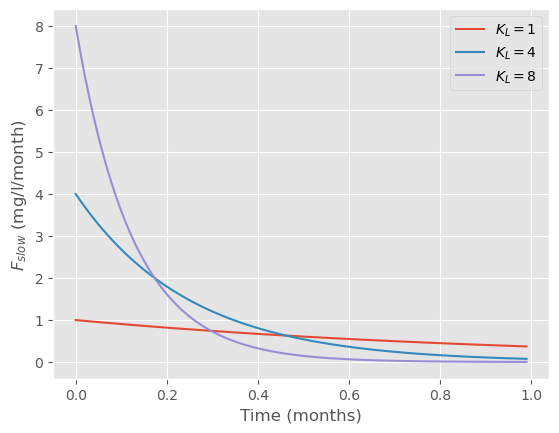

In [2]:
# Plot different values for K_L
fig = plt.figure()
KLs = [1, 4, 8]
xs = np.arange(0, 1, 0.01)
for KL in KLs:
    ys = KL * np.exp(-KL * xs)
    plt.plot(xs, ys, ls="-", label=f"$K_L = {KL}$")
plt.xlabel("Time (months)")
plt.ylabel("$F_{slow}$ (mg/l/month)")
plt.legend()

## 2. Changing hydrology

Water residence time is a key parameter influencing the effectiveness and required frequency for lake liming. Lakes with short residence times are "refreshed" more quickly, meaning that liming is required more often. In the model defined here, users must supply the lake volume (i.e. surface area and mean depth) and the residence time, $\tau$. These are then used to calculate the mean annual flow rate, $Q$. 

Within each year, TPKALK uses a set of monthly flow scaling factors for lakes with different typical flow regimes (see [Fig. 16 of the TPKALK report](https://niva.brage.unit.no/niva-xmlui/bitstream/handle/11250/208709/3412_200dpi.pdf?sequence=2&isAllowed=y#page=22)). These factors are applied to the annual mean to give flow estimates for each month. TPKALK originally considered five "standard" flow regimes, of which the most commonly used were `fjell` and `kyst`. I have included these two for now, plus the option to use a fixed flow for the entire year (flow profile = `none`).

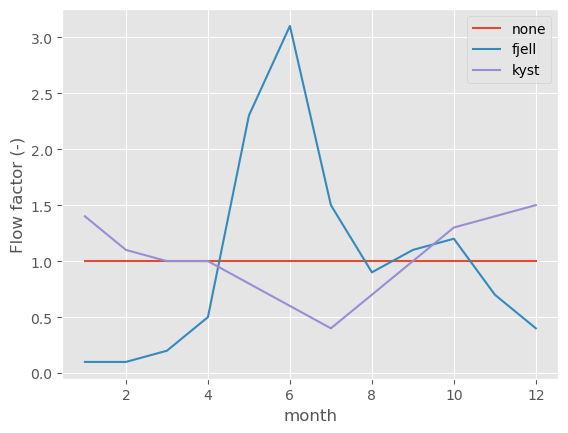

In [3]:
# Read monthly flow factors
q_df = pd.read_excel("../data/flow_typologies.xlsx", index_col=0)
ax = q_df.plot()
ax.set_ylabel("Flow factor (-)");

## 2. Model code

Initial model code is in `model.py`.

## 3. Lime data

Currently hard-coded at the top of `model.py`. Should be moved into either a JSON file or a database.

## 4. User input

Users must supply the following input to simulate changes in Ca concentration.

#### Initial conditions
 
        C_lake0                  # Lake Ca concentration (mg/l)
        C_in0                    # Lake inflow concentration (mg/l)
        C_bott0                  # "Active" lime on the lake bottom at t=0 (mg/l)
        pH_lake0                 # Lake pH
        
#### Liming parameters
 
        lime_prod                # Name of product. Must be in the "database"
        lime_dose                # Dose as lime (not Ca) in mg/l
        lime_month               # Month in which lime is added. Must be < 'n_months'
        spr_meth                 # 'wet' or 'dry'
        K_L                      # Rate of dissolution of "active" bottom lime (month^-1)
        F_active                 # Proportion of lake-bottom lime that remains "active" (i.e. available for dissolution)

#### Lake characteristics
 
        area                     # km2
        mean_depth               # metres
        res_time                 # Volume / mean_annual_q
        flow_profile             # 'none', 'fjell' or 'kyst'

#### Model setup
 
        n_months                 # Number of months to simulate

## 5. Run the model

For all the examples below we will use the following common setup for lake initial conditions and characteristics.

In [4]:
# Initial conditions
C_lake0 = 1  # Lake Ca concentration (mg/l)
C_in0 = 1  # Lake inflow concentration (mg/l)
C_bott0 = 0  # "Active" lime on the lake bottom at t=0 (mg/l)
pH_lake0 = 4.5  # Lake pH

# Lake characteristics
area = 0.2  # km2
mean_depth = 5  # m

# Model setup
n_months = 24  # Number of months to simulate

### 5.1. Fixed hydrology and liming parameters

Liming in month 1 with `flow_profile = 'none'` for a fixed liming product, dose etc.

In [5]:
# Liming parameters
lime_prod = "Miljøkalk EY3"  # Must be in the "database"
lime_dose = 10  # Dose as lime (not Ca) in mg/l
lime_month = 1  # Month in which lime is added. Must be < 'n_months'
spr_meth = "wet"  # 'wet' or 'dry'
K_L = 1  # month^-1
F_active = 0.4  # Proportion of lake-bottom lime that remains "active" (i.e. available for dissolution)

# Hydrology parameters
res_time = 0.7  # Volume / mean_annual_q
flow_profile = "none"  # 'none', 'fjell' or 'kyst'

In [6]:
par_dict = {
    "C_lake0": C_lake0,
    "C_in0": C_in0,
    "C_bott0": C_bott0,
    "pH_lake0": pH_lake0,
    "lime_prod": lime_prod,
    "lime_dose": lime_dose,
    "lime_month": lime_month,
    "spr_meth": spr_meth,
    "K_L": K_L,
    "F_active": F_active,
    "area": area,
    "mean_depth": mean_depth,
    "res_time": res_time,
    "flow_profile": flow_profile,
    "n_months": n_months,
}

df = model.run_ca_model(par_dict)
df.head()

,C_lake0,pH_lake0,K_L,F_active,flow_profile,lime_prod,lime_dose,spr_meth,res_time,Ca (mg/l)
1.00,1,4.5,1,0.4,none,Miljøkalk EY3,10,wet,0.7,3.710400
1.01,1,4.5,1,0.4,none,Miljøkalk EY3,10,wet,0.7,3.711708
1.02,1,4.5,1,0.4,none,Miljøkalk EY3,10,wet,0.7,3.712970
1.03,1,4.5,1,0.4,none,Miljøkalk EY3,10,wet,0.7,3.714185
1.04,1,4.5,1,0.4,none,Miljøkalk EY3,10,wet,0.7,3.715355


<AxesSubplot:>

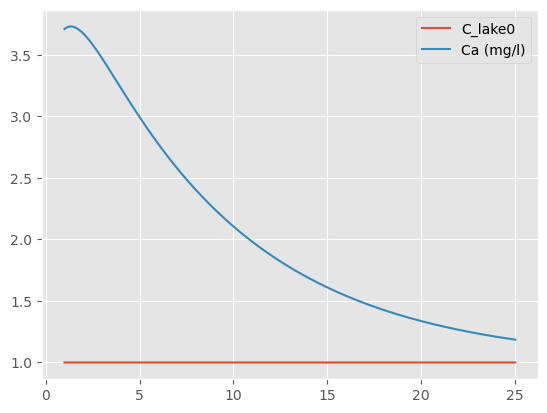

In [7]:
df[["C_lake0", "Ca (mg/l)"]].plot()

### 5.2. Variable residence time (but fixed through time) with different lime products, doses etc.

Assume flow is fixed through the year (`flow_profile = 'none'`), but consider a range of values for residence time (i.e. several different mean annual flows). Also vary the lime product, dose and spreading method.

In [8]:
# Liming parameters
lime_prods = ["Miljøkalk EY3", "Miljøkalk VK3", "SK2"]
lime_doses = [10, 20, 35]
lime_month = 1  # Month in which lime is added. Must be < 'n_months'
spr_meths = ["wet", "dry"]
K_L = 1  # month^-1
F_active = 0.4  # Proportion of lake-bottom lime that remains "active" (i.e. available for dissolution)

# Hydrology
res_times = [0.1, 0.4, 0.7, 1, 1.3, 1.6]  # Residence times in years
flow_profile = "none"  # 'none', 'fjell' or 'kyst'

In [9]:
# Loop over combinations
df_list = []
for spr_meth in spr_meths:
    for res_time in res_times:
        for lime_dose in lime_doses:
            for lime_prod in lime_prods:
                par_dict = {
                    "C_lake0": C_lake0,
                    "C_in0": C_in0,
                    "C_bott0": C_bott0,
                    "pH_lake0": pH_lake0,
                    "lime_prod": lime_prod,
                    "lime_dose": lime_dose,
                    "lime_month": lime_month,
                    "spr_meth": spr_meth,
                    "K_L": K_L,
                    "F_active": F_active,
                    "area": area,
                    "mean_depth": mean_depth,
                    "res_time": res_time,
                    "flow_profile": flow_profile,
                    "n_months": n_months,
                }
                df = model.run_ca_model(par_dict, dt=0.5)
                df.index.name = "Time (months)"
                df.reset_index(inplace=True)
                df_list.append(df)
df = pd.concat(df_list, axis="rows")
df.head()

,Time (months),C_lake0,pH_lake0,K_L,F_active,flow_profile,lime_prod,lime_dose,spr_meth,res_time,Ca (mg/l)
0,1.0,1,4.5,1,0.4,none,Miljøkalk EY3,10,wet,0.1,3.710400
1,1.5,1,4.5,1,0.4,none,Miljøkalk EY3,10,wet,0.1,2.930970
2,2.0,1,4.5,1,0.4,none,Miljøkalk EY3,10,wet,0.1,2.360413
3,2.5,1,4.5,1,0.4,none,Miljøkalk EY3,10,wet,0.1,1.949875
4,3.0,1,4.5,1,0.4,none,Miljøkalk EY3,10,wet,0.1,1.658363


In [10]:
# Plot
df2 = df.query("spr_meth == 'wet'")
alt.Chart(df2).mark_line().encode(
    x="Time (months):Q", y="Ca (mg/l):Q", color="res_time:N"
).properties(width=300, height=200,).facet(
    column="lime_dose:O",
    row="lime_prod:N",
)

alt.FacetChart(...)

### 5.3. Fixed liming parameters with variable flows

In [11]:
# Liming parameters
lime_prod = "Miljøkalk EY3"
lime_dose = 10
lime_month = 7  # Month in which lime is added. Must be < 'n_months'
spr_meth = "wet"
K_L = 1  # month^-1
F_active = 0.4  # Proportion of lake-bottom lime that remains "active" (i.e. available for dissolution)

# Hydrology
res_time = 0.7  # Volume / mean_annual_q
flow_profile = "fjell"  # 'none', 'fjell' or 'kyst'

In [12]:
par_dict = {
    "C_lake0": C_lake0,
    "C_in0": C_in0,
    "C_bott0": C_bott0,
    "pH_lake0": pH_lake0,
    "lime_prod": lime_prod,
    "lime_dose": lime_dose,
    "lime_month": lime_month,
    "spr_meth": spr_meth,
    "K_L": K_L,
    "F_active": F_active,
    "area": area,
    "mean_depth": mean_depth,
    "res_time": res_time,
    "flow_profile": flow_profile,
    "n_months": n_months,
}
df = model.run_ca_model(par_dict)
df.head()

,C_lake0,pH_lake0,K_L,F_active,flow_profile,lime_prod,lime_dose,spr_meth,res_time,Ca (mg/l)
1.00,1,4.5,1,0.4,fjell,Miljøkalk EY3,10,wet,0.7,1.0
1.01,1,4.5,1,0.4,fjell,Miljøkalk EY3,10,wet,0.7,1.0
1.02,1,4.5,1,0.4,fjell,Miljøkalk EY3,10,wet,0.7,1.0
1.03,1,4.5,1,0.4,fjell,Miljøkalk EY3,10,wet,0.7,1.0
1.04,1,4.5,1,0.4,fjell,Miljøkalk EY3,10,wet,0.7,1.0


<AxesSubplot:>

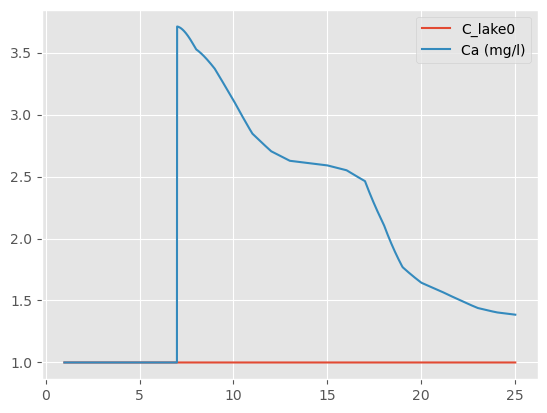

In [13]:
df[["C_lake0", "Ca (mg/l)"]].plot()

## Testing

In [14]:
model.est_res_time_from_lake_props(1.14, 5.6, 0.2)

1.0121765601217656

In [15]:
# Initial conditions
C_lake0 = 1  # Lake Ca concentration (mg/l)
C_in0 = 1  # Lake inflow concentration (mg/l)
C_bott0 = 0  # "Active" lime on the lake bottom at t=0 (mg/l)
pH_lake0 = 4.5  # Lake pH

# Liming parameters
lime_prod = "SK2"
lime_dose = 7.8
lime_month = 1  # Month in which lime is added. Must be < 'n_months'
spr_meth = "wet"
K_L = 1  # month^-1
F_active = 0.4  # Proportion of lake-bottom lime that remains "active" (i.e. available for dissolution)

# Lake characteristics
area = 1.14  # km2
mean_depth = 5.6  # m

# Hydrology
res_time = 1  # Volume / mean_annual_q
flow_profile = "fjell"  # 'none', 'fjell' or 'kyst'

# Model setup
n_months = 24  # Number of months to simulate

,C_lake0,pH_lake0,K_L,F_active,lime_dose,res_time,Ca (mg/l)
count,241.0,241.0,241.0,2.410000e+02,2.410000e+02,241.0,241.000000
mean,1.0,4.5,1.0,4.000000e-01,7.800000e+00,1.0,1.917353
std,0.0,0.0,0.0,1.168160e-15,3.026091e-14,0.0,0.546682
min,1.0,4.5,1.0,4.000000e-01,7.800000e+00,1.0,1.268909
25%,1.0,4.5,1.0,4.000000e-01,7.800000e+00,1.0,1.436028
50%,1.0,4.5,1.0,4.000000e-01,7.800000e+00,1.0,1.737084
75%,1.0,4.5,1.0,4.000000e-01,7.800000e+00,1.0,2.194101
max,1.0,4.5,1.0,4.000000e-01,7.800000e+00,1.0,2.936553


<AxesSubplot:>

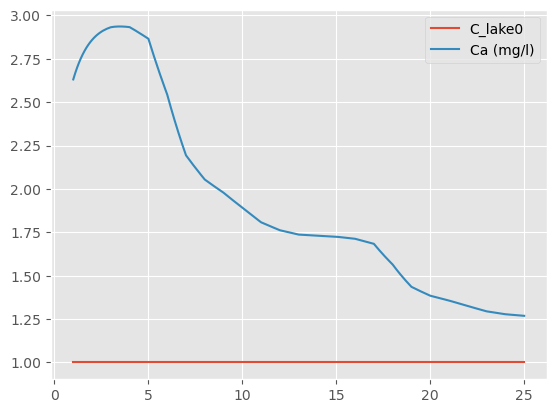

In [16]:
par_dict = {
    "C_lake0": C_lake0,
    "C_in0": C_in0,
    "C_bott0": C_bott0,
    "pH_lake0": pH_lake0,
    "lime_prod": lime_prod,
    "lime_dose": lime_dose,
    "lime_month": lime_month,
    "spr_meth": spr_meth,
    "K_L": K_L,
    "F_active": F_active,
    "area": area,
    "mean_depth": mean_depth,
    "res_time": res_time,
    "flow_profile": flow_profile,
    "n_months": n_months,
}
df = model.run_ca_model(par_dict, dt=0.1)
display(df.describe())
df[["C_lake0", "Ca (mg/l)"]].plot()